# Example RNN Training
- (already processed) data prep
    - run preprpcessing notebook first
- RNN definition
- Training session
- Evaluate with visualization

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from keras.layers import Input, LSTM, BatchNormalization, Dense
from keras import Model
from keras.initializers import RandomNormal, Ones, Constant
from keras.optimizers import Adam

from crypr.util import get_project_path

coin = 'BTC'
data_path = join(get_project_path(), 'data', 'processed')

Using TensorFlow backend.


In [2]:
"""
Import Data.
"""
Ty = 1
Tx = 72
feature_lag = 72

X_train = np.load(join(data_path, 'X_train_{}.npy'.format(coin)))
Y_train = np.load(join(data_path, 'Y_train_{}.npy'.format(coin)))
X_test = np.load(join(data_path, 'X_test_{}.npy'.format(coin)))
Y_test = np.load(join(data_path, 'Y_test_{}.npy'.format(coin)))

N_FEATURES = X_train.shape[2]

In [3]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, Y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=Y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=Y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.3415146127366283
mean MSE: 0.4479457734182177

Performance on test data:
mean MAE: 0.4554041031711689
mean MSE: 0.8425114174364235

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.3413280233955457
median MSE: 0.4480662046382997

Performance on test data:
median MAE: 0.45504805273470056
median MSE: 0.8408456242821171

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.34135380646531016
constant MSE: 0.4479821748318338

Performance on test data:
constant MAE: 0.4551988868989661
constant MSE: 0.8415657869557692


In [4]:
"""
Scale each channels' data.
(source: Top answer from https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix)
"""
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[2]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [5]:
"""
Define RNN Model.
"""
def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'): 
    model_input = Input(shape=input_shape, dtype='float32')

    X = LSTM(units=64, return_sequences=True, kernel_initializer=kernel_init, bias_initializer=bias_init)(model_input)
    X = BatchNormalization(axis=-1)(X)
    
    X = LSTM(units=64, return_sequences=False, kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
    X = BatchNormalization(axis=-1)(X)
    
    X = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear')(X)

    return Model(inputs=model_input, outputs=X)

In [6]:
model = lstm_model(X_train.shape[1:], num_outputs=Ty)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 18)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 72, 64)            21248     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 54,849
Trainable params: 54,593
Non-trainable params: 25

In [7]:
"""
Set model training parameters.
"""
epochs = 5
batch_size = 32
learning_rate = 1e-3
decay_rate = learning_rate / epochs

"""
Compile and fit model.
"""
model.compile(loss='mse', optimizer=Adam(lr=learning_rate, decay=decay_rate), metrics=['mae'])

fit = model.fit(
    X_train, 
    Y_train,
    shuffle=True,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, Y_test),
)

Instructions for updating:
Use tf.cast instead.
Train on 5586 samples, validate on 294 samples
Epoch 1/5
5586/5586 [==============================] - 25s 5ms/step - loss: 0.4808 - mean_absolute_error: 0.3791 - val_loss: 0.8649 - val_mean_absolute_error: 0.4791
Epoch 2/5
5586/5586 [==============================] - 24s 4ms/step - loss: 0.4604 - mean_absolute_error: 0.3607 - val_loss: 0.9348 - val_mean_absolute_error: 0.5237
Epoch 3/5
5586/5586 [==============================] - 24s 4ms/step - loss: 0.4588 - mean_absolute_error: 0.3554 - val_loss: 0.9115 - val_mean_absolute_error: 0.4957
Epoch 4/5
5586/5586 [==============================] - 24s 4ms/step - loss: 0.4522 - mean_absolute_error: 0.3490 - val_loss: 0.8525 - val_mean_absolute_error: 0.4686
Epoch 5/5
5586/5586 [==============================] - 23s 4ms/step - loss: 0.4513 - mean_absolute_error: 0.3481 - val_loss: 0.8615 - val_mean_absolute_error: 0.4631


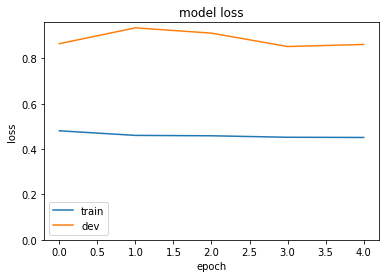

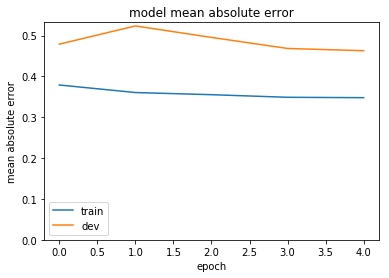

In [8]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()

"""
Check out mean absolute error from train and dev sets
"""
plt.plot(fit.history['mean_absolute_error'], label='train')
plt.plot(fit.history['val_mean_absolute_error'], label='dev')
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()

In [9]:
backtest = model.predict(X_train)
prediction = model.predict(X_test)

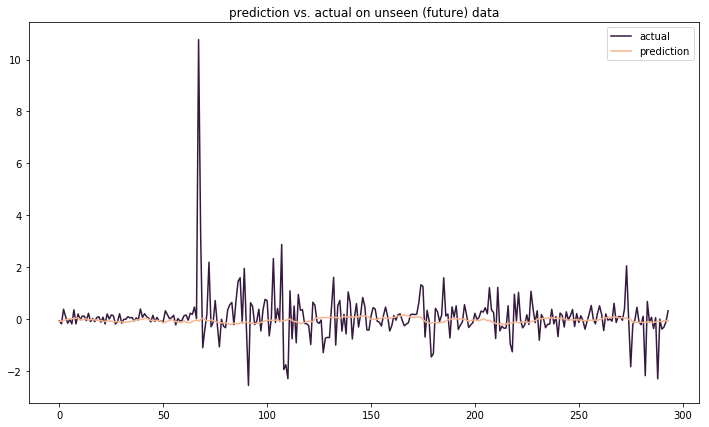

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(Y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()
plt.show()

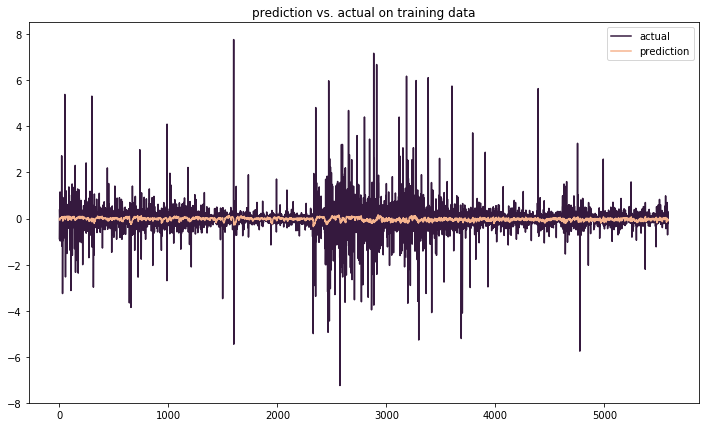

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(Y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()
plt.show()